# Sequential rumour stance prediction

Rumours tend to change over time; people focus on different aspects of a story.<br>
We could view this process as a word space distribution that evolves over time. 

## Subspace alignment

Here we will tackle this problem using a [Subspace Aligned Classifier](https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf).

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import scipy.stats as st
import pickle as pc
import dateutil
import numpy.random as rnd

# Import feature extractors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer

# Import visualizers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Import classifiers
from sklearn import svm
from sklearn import linear_model
from sklearn import neighbors
from subalign import SubspaceAlignedClassifier

# Import class imbalance techniques
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set font size
fS = 20

In [14]:
# Experimental parameters
which_rumour = 'charliehebdo'
classifier = 'lr'
kernel = 'poly'
degree = 3
l2 = None
subspace_dim = 50

In [15]:
# Load data
X = np.load('../data/RumEval2019/rumeval19.npy')
tweets = pd.read_json('../data/RumEval2019/RumEval19.json')

X[np.isnan(X)] = 0

In [16]:
# Show rumours
rumours_ = tweets['rumour'].tolist()
rumours = np.unique(tweets['rumour'].tolist())
[print(rumour) for rumour in rumours];

# Show dates
# dates_ = [dateutil.parser.parse(date).date() for date in tweets['date'].tolist()]
dates_ = [date.date() for date in tweets['date'].tolist()]
dates = np.unique(dates_)

charliehebdo
ebola-essien
ferguson
germanwings-crash
illary
ottawashooting
prince-toronto
putinmissing
sydneysiege


## Sequential prediction over rumours

In [17]:
# Load data
X = np.load('../data/RumEval2019/rumeval19.npy')
tweets = pd.read_json('../data/RumEval2019/RumEval19.json')

# Impute NaN
X[np.isnan(X)] = 0

# Subselect labels and map to numerical
labels_ = tweets['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])

In [18]:
# Sort tweets by dates
tweets = tweets.sort_values(by=['date'])

dates_ = tweets['date'].values
dates = np.unique(tweets['date'].values)
sortix = np.argsort(dates_)

rumours_ = tweets['rumour'].values[sortix]
indexes = np.unique(rumours_, return_index=True)[1]
all_rumours = [rumours_[index] for index in sorted(indexes)]

In [19]:
# Remove rumours with too few samples
cutoff = subspace_dim
rumours = []
for rumour in all_rumours:
    
    # Number of samples for current rumour
    num_rumour = np.sum(rumours_ == rumour)
    
    if num_rumour >= cutoff:
        rumours.append(rumour)
        
print('{} rumours discarded for having less than {} samples.\n'.format(len(all_rumours) - len(rumours), cutoff))

print('Remaining rumours:')
[print(rumour) for rumour in rumours];

1 rumours discarded for having less than 50 samples.

Remaining rumours:
ferguson
ottawashooting
prince-toronto
sydneysiege
charliehebdo
putinmissing
germanwings-crash
illary


In [20]:
# Preallocation
nperf_array = []
aperf_array = []
sub_dim_r = []
mappings = []

# Start looping over rumours
for r in range(1, len(rumours)):
    
    print('At rumour ' + rumours[r])
    
    # Set range up to yesterday
    past = slice(0,r)

    # Create training data from all previous days
    trn_index = tweets['rumour'].isin(rumours[past]).values

    # Find all tweets from today
    tst_index = (tweets['rumour'] == rumours[r]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Set up class balancing
    trn_X, trn_Y = RandomOverSampler().fit_resample(trn_X, trn_Y)
    
    # Check label proportions
    print('Label shape of train set, after resampling: \t %s' % Counter(trn_Y))
    
    # Sample size
    N = trn_X.shape[0]
    M = tst_X.shape[0]
    
    # Store subspace dimension of current rumour
    sub_dim_r.append(min(subspace_dim, min(N, M)))
    
    # Z-score data
    trn_X = st.zscore(trn_X)
    tst_X = st.zscore(tst_X)
    
    # Adaptive classifier
    aclf = SubspaceAlignedClassifier(l2_regularization=l2, subspace_dim=min(subspace_dim, min(N, M)))
    
    # Store transformation matrix
    V, _, _ = aclf.subspace_alignment(trn_X, tst_X, subspace_dim=min(subspace_dim, min(N, M)))
    mappings.append(V)
    
    # Define classifier
    if classifier in ('lr', 'logr', 'logistic'):
        
        if l2:
            # Linear logistic model
            nclf = linear_model.LogisticRegression(C=l2, multi_class='auto', solver='lbfgs')
            
        else:
            # Linear logistic model
            nclf = linear_model.LogisticRegressionCV(cv=5, solver='lbfgs')    
        
    elif classifier in ('knn'):
        
        # Polynomial support vector machine
        nclf = neighbors.KNeighborsClassifier()
        
    elif classifier in ('svm', 'svc', 'rbfsvc'):
        
        # Polynomial support vector machine
        nclf = svm.SVC(kernel=kernel, gamma='auto', C=l2)
        
    else:
        raise ValueError('Classifier not recognized')

    # Train classifier on labeled data from previous days
    nclf.fit(trn_X, trn_Y)
    
    # Train classifier on labeled data from previous days, aligned to unlabeled data from today
    aclf.fit(trn_X, trn_Y, tst_X)

    # Make predictions on test set
    npreds = nclf.predict(tst_X)
    apreds = aclf.predict(tst_X)

    # Test on data from current day and store
    nperf_array.append(np.mean(npreds == tst_Y))
    aperf_array.append(np.mean(apreds == tst_Y))

# Compact to DataFrame
rum_results = pd.DataFrame({'rumours': rumours[1:],
                            'acc_naive': nperf_array,
                            'acc_adaptive': aperf_array,
                            'subspace_dim': sub_dim_r},
                           columns=['rumours', 'acc_naive', 'acc_adaptive', 'sub_dim_r'])    

At rumour ottawashooting
Label shape of train set, after resampling: 	 Counter({3: 735, 2: 735, 0: 735, 1: 735})
At rumour prince-toronto
Label shape of train set, after resampling: 	 Counter({3: 1313, 2: 1313, 0: 1313, 1: 1313})
At rumour sydneysiege
Label shape of train set, after resampling: 	 Counter({3: 1373, 2: 1373, 0: 1373, 1: 1373})
At rumour charliehebdo
Label shape of train set, after resampling: 	 Counter({3: 2141, 2: 2141, 0: 2141, 1: 2141})
At rumour putinmissing
Label shape of train set, after resampling: 	 Counter({3: 2935, 2: 2935, 0: 2935, 1: 2935})
At rumour germanwings-crash
Label shape of train set, after resampling: 	 Counter({3: 2976, 2: 2976, 0: 2976, 1: 2976})
At rumour illary
Label shape of train set, after resampling: 	 Counter({3: 3272, 2: 3272, 0: 3272, 1: 3272})


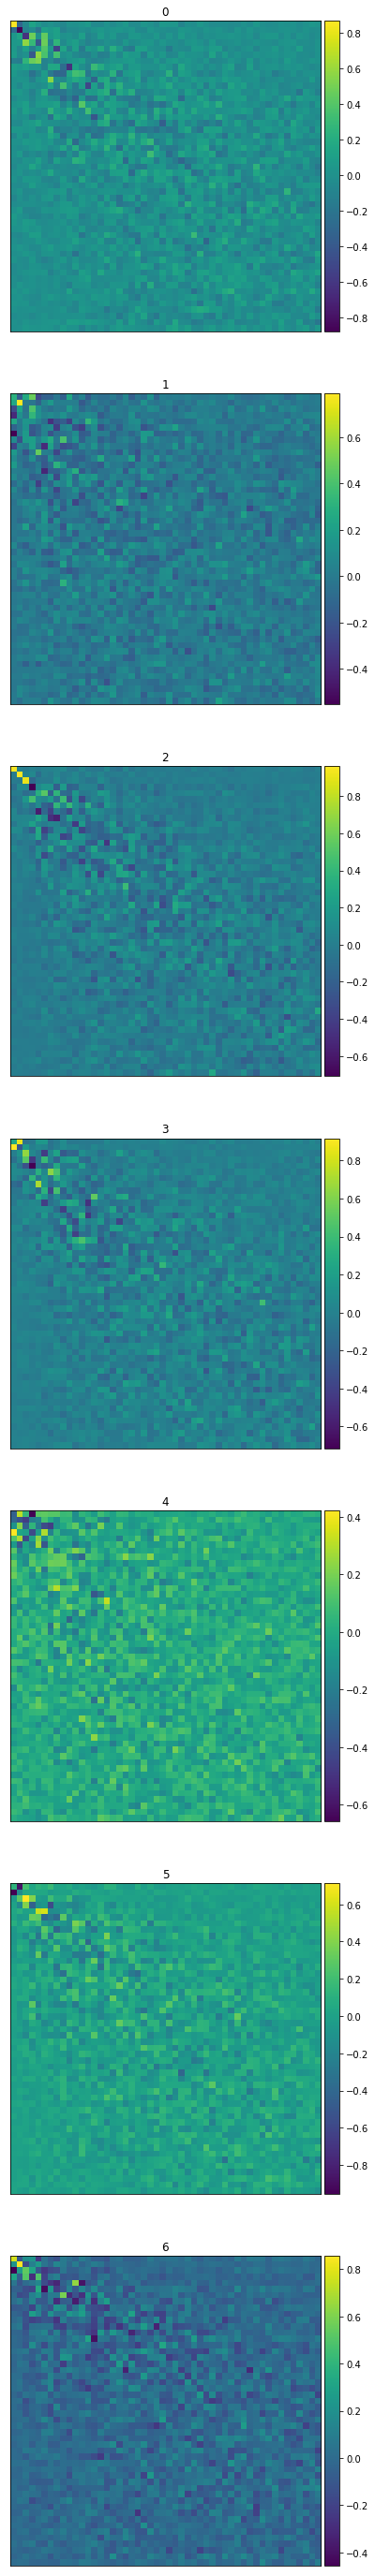

In [21]:
fig, ax = plt.subplots(nrows=len(mappings), figsize=(15,50))

for m, mapping in enumerate(mappings):
    
    im = ax[m].imshow(mapping)
    divider = make_axes_locatable(ax[m])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[m].get_xaxis().set_visible(False)
    ax[m].get_yaxis().set_visible(False)
    ax[m].set_title(m)

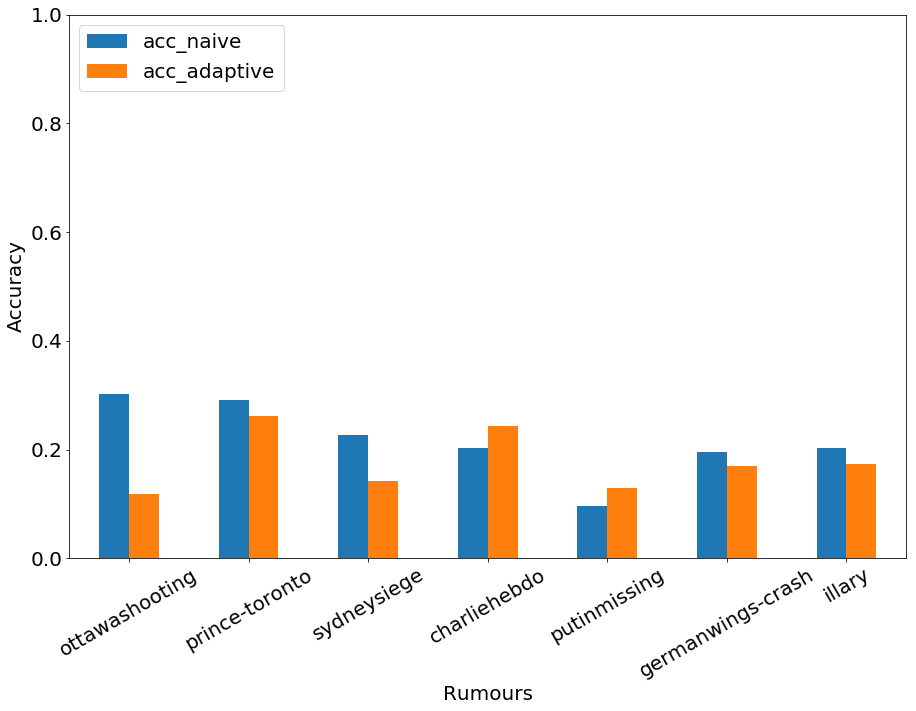

In [22]:
# Visualize performance in bar graph

fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
rum_results.plot.bar(ax=ax, x='rumours', y=["acc_naive", "acc_adaptive"], rot=30, fontsize=fS, legend=True);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=2);
ax.set_xlabel('Rumours', fontsize=fS);
ax.set_ylabel('Accuracy', fontsize=fS);

fig.savefig('exp-stance_rumEval19_subalign_dim' + str(subspace_dim) + '_bar-rumours.png', bbox_inches='tight', padding=None)

In [ ]:
# Initialize figure
fig, ax = plt.subplots(nrows=len(rumours)-2, ncols=3, sharex=True, sharey=True, figsize=(30, 40))


# Start looping over rumours
for r in range(1, len(rumours)-1):
    
    print('At rumour ' + rumours[r])
    
    # Set range up to yesterday
    past = slice(0,r)

    # Create training data from all previous days
    trn_index = tweets['rumour'].isin(rumours[past]).values

    # Find all tweets from today
    tst_index = (tweets['rumour'] == rumours[r]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Z-score data
    trn_X = st.zscore(trn_X)
    tst_X = st.zscore(tst_X)
    
    # Find subspace
    clf = SubspaceAlignedClassifier(subspace_dim=2)
    V, CX, CZ = clf.subspace_alignment(trn_X, tst_X, subspace_dim=2)
    
    # Map data onto components
    X_ = trn_X @ CX
    Z_ = tst_X @ CZ
    
    # Transformed X
    XV = X_ @ V
    
    for l, label in enumerate(labels):

        ax[r-1][0].scatter(X_[(trn_Y == l), 0], X_[(trn_Y == l), 1], label=label)
        ax[r-1][0].set_title('Past rumours (' + ', '.join(rumours[past]) + ')')
        ax[r-1][0].set_xlabel('p_1')
        ax[r-1][0].set_ylabel('p_2')
        ax[r-1][0].legend(fontsize=fS)
        
        ax[r-1][1].scatter(XV[(trn_Y == l), 0], XV[(trn_Y == l), 1], label=label)
        ax[r-1][1].set_title('Transformed')
        ax[r-1][1].set_xlabel('p_1')
        ax[r-1][1].set_ylabel('p_2')
        ax[r-1][1].legend(fontsize=fS)
        
        ax[r-1][2].scatter(Z_[(tst_Y == l), 0], Z_[(tst_Y == l), 1], label=label)
        ax[r-1][2].set_title(rumours[r])
        ax[r-1][2].set_xlabel('p_1')
        ax[r-1][2].set_ylabel('p_2')
        ax[r-1][2].legend(fontsize=fS)
    
plt.savefig('exp-stance_rumEval19_subalign_rumours.png', bbox_inches=None, padding='tight')    
plt.show()

## Sequential prediction over days

In [ ]:
# Subselect labels and map to numerical
labels_ = tweets['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])

In [ ]:
# Select dates
dates_ = tweets['date'].values

all_dates = np.unique(dates_)

# Remove dates with too few samples
cutoff = 10
dates = []
for date in all_dates:
    
    # Number of samples for current date
    num_date = np.sum(dates_ == date)
    
    if num_date > cutoff:
        dates.append(date)
        
print('{} dates discarded for having less than {} samples.'.format(len(all_dates) - len(dates), cutoff))

Maybe it would be a good idea to forget older rumours. Like an exponentially decaying weighting.

In [ ]:
# Classification experiment

# Preallocate performance array
nperf_array = []
aperf_array = []
days_array = []
sub_dim_d = []
mappings = []

# Loop over days
for d in range(1, len(dates)-1):

    # Set range up to yesterday
    past = slice(0,d)

    # Create training data from all previous days
    trn_index = tweets['date'].isin(dates[past]).values

    # Find all tweets from today
    tst_index = (tweets['date'] == dates[d]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Set up under-sampling using specified classifier
    trn_X, trn_Y = RandomOverSampler().fit_resample(trn_X, trn_Y)
    
    # Check label proportions
    print('Label shape of train set, after resampling: \t %s' % Counter(trn_Y))
    
    # Sample size
    N = trn_X.shape[0]
    M = tst_X.shape[0]
    
    # Store subspace dimensionality
    sub_dim_d.append(min(subspace_dim, min(N, M)))
    
    if not M == 1:
        
        # Z-score data
        trn_X = st.zscore(trn_X, axis=0)
        tst_X = st.zscore(tst_X, axis=0)
    
    # Adaptive classifier
    aclf = SubspaceAlignedClassifier(loss_function=classifier, l2_regularization=l2, )
    V, CX, CZ = aclf.subspace_alignment(trn_X, tst_X, subspace_dim=min(subspace_dim, min(N, M)))
    
    # Store mappings
    mappings.append(V)
    
    # Define classifier
    if classifier in ('lr', 'logr', 'logistic'):
        
        # Linear logistic model
        nclf = linear_model.LogisticRegression(C=l2, multi_class='auto', solver='lbfgs')
    
    elif classifier in ('knn'):
        
        # Polynomial support vector machine
        nclf = neighbors.KNeighborsClassifier()
        
    elif classifier in ('svm', 'svc', 'rbfsvc'):
        
        # Polynomial support vector machine
        nclf = svm.SVC(kernel=kernel, gamma='auto', C=l2)
        
    else:
        raise ValueError('Classifier not recognized')

    # Train classifier on labeled data from previous days
    nclf.fit(trn_X, trn_Y)
    
    # Train classifier on labeled data from previous days, aligned to unlabeled data from today
    aclf.fit(trn_X, trn_Y)

    # Make predictions on test set
    npreds = nclf.predict(tst_X)
    apreds = aclf.predict(tst_X)

    # Test on data from current day and store
    nperf_array.append(np.mean(npreds == tst_Y))
    aperf_array.append(np.mean(apreds == tst_Y))

# Compact to DataFrame
results = pd.DataFrame({'dates': dates[1:-1],
                        'acc_naive': nperf_array,
                        'acc_adaptive': aperf_array,
                        'subspace_dim': sub_dim_d},
                        columns=['dates', 'acc_naive', 'acc_adaptive', 'subspace_dim'])    
results

In [ ]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 50))

# Bar plot
results.plot.barh(ax=ax, x='dates', y=["acc_naive", "acc_adaptive"], fontsize=fS, legend=True);

# Set axes properties
# ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=1);
ax.set_ylabel('Days', fontsize=fS);
ax.set_xlabel('Accuracy', fontsize=fS);

fig.savefig('exp-stance_rumEval19_subalign' + str(subspace_dim) + '_bar-dates-allrumours.png', bbox_inches='tight', padding=None)